Let's load and pre-process data

In [40]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:

nltk.download('punkt')
reddit = pd.read_json("../data/old/reddit_comments.json")
twitter = pd.read_csv("../data/old/twitter.csv")
YouTubeVideo = pd.read_excel("../data/old/ICWSM18 - SALMINEN ET AL.xlsx")
YouTube = YouTubeVideo[YouTubeVideo["type"].str.contains("post") == False]
fb = YouTubeVideo[YouTubeVideo["type"].str.contains("video") == False]
dfs = {"Reddit": reddit, "Twitter": twitter,"Youtube": YouTubeVideo, "Facebook": fb}

def overview(dfs):
    for name, df in dfs.items():
        print("\n")
        print(f"{name} description")
        print(df.info())
        print("\n")
        print(f"{name} example")
        print(df.head(5))

overview(dfs)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




Reddit description
<class 'pandas.core.frame.DataFrame'>
Index: 18870 entries, 0 to 18869
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _replies                         18870 non-null  object 
 1   id                               18870 non-null  object 
 2   total_awards_received            18870 non-null  int64  
 3   approved_at_utc                  0 non-null      float64
 4   comment_type                     0 non-null      float64
 5   edited                           18870 non-null  int64  
 6   mod_reason_by                    0 non-null      float64
 7   banned_by                        0 non-null      float64
 8   author_flair_type                14966 non-null  object 
 9   removal_reason                   0 non-null      float64
 10  link_id                          18870 non-null  object 
 11  author_flair_template_id         857 non-null    object 
 12  li

In [28]:
def standardize_datasets(dfs):
    dfs["Twitter"] = dfs["Twitter"][["tweet", "class"]]
    dfs["Twitter"] = dfs["Twitter"].rename(columns={"tweet": "text", "class": "label"})
    # 0 indicates hate speech, 2 indicates nothing. we need to reencode to 0, 1. (0=no hate speech, 1=hate speech).
    dfs["Twitter"]["label"] = dfs["Twitter"]["label"].replace({0: 1, 2: 0})
    dfs["Reddit"] = dfs["Reddit"][["body", "is_hate"]]
    dfs["Reddit"] = dfs["Reddit"].rename(columns={"body": "text", "is_hate": "label"})
    dfs["Youtube"] = dfs["Youtube"][["message", "Class"]]
    dfs["Youtube"] = dfs["Youtube"].rename(columns={"message": "text", "Class": "label"})
    dfs["Youtube"]["label"] = dfs["Youtube"]["label"].replace({"Hateful": 1, "Neutral": 0})
    dfs["Facebook"] = dfs["Facebook"][["message", "Class"]]
    dfs["Facebook"] = dfs["Facebook"].rename(columns={"message": "text", "Class": "label"})
    dfs["Facebook"]["label"] = dfs["Facebook"]["label"].replace({"Hateful": 1, "Neutral": 0})

standardize_datasets(dfs)
overview(dfs)




Reddit description
<class 'pandas.core.frame.DataFrame'>
Index: 18870 entries, 0 to 18869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    18870 non-null  object 
 1   label   18860 non-null  float64
dtypes: float64(1), object(1)
memory usage: 442.3+ KB
None


Reddit example
                                                text  label
0  A subsection of retarded Hungarians? Ohh boy. ...    1.0
1  Hiii. Just got off work. 444 is mainly the typ...    0.0
2  wow i guess soyboys are the same in every country    0.0
3  Owen Benjamin's soyboy song goes for every cou...    0.0
4  wouldn't the defenders or whatever they are as...    1.0


Twitter description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24783 non-null  object
 1   label   24783 non-null  int64 
dtypes: int64(1), 

C:\Users\david\AppData\Local\Temp\ipykernel_28004\3535023289.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfs["Youtube"]["label"] = dfs["Youtube"]["label"].replace({"Hateful": 1, "Neutral": 0})
C:\Users\david\AppData\Local\Temp\ipykernel_28004\3535023289.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfs["Facebook"]["label"] = dfs["Facebook"]["label"].replace({"Hateful": 1, "Neutral": 0})


Let's check for missing values

In [29]:
def check_for_missing_values(dfs):
    for name, df in dfs.items():
        print(f"{name}")
        print(df.isnull().sum())

check_for_missing_values(dfs)

Reddit
text      0
label    10
dtype: int64
Twitter
text     0
label    0
dtype: int64
Youtube
text     1
label    0
dtype: int64
Facebook
text     1
label    0
dtype: int64


let's drop missings

In [30]:
def drop_missings(dfs):
    for name, df in dfs.items():
        df.dropna(inplace=True)

drop_missings(dfs)
check_for_missing_values(dfs)

Reddit
text     0
label    0
dtype: int64
Twitter
text     0
label    0
dtype: int64
Youtube
text     0
label    0
dtype: int64
Facebook
text     0
label    0
dtype: int64


Let's do some visualization

In [31]:
# Functions to calculate number of words and sentences
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def process_df(df):
    # Apply functions to DataFrame
    df['num_words'] = df['text'].apply(count_words)
    df['num_sentences'] = df['text'].apply(count_sentences)

for name, df in dfs.items():
    process_df(df)

In [ ]:
def plot_num_words(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs)
plot_num_sentences(dfs)

Let's plot with an upper boundary on outliers, for better visibility

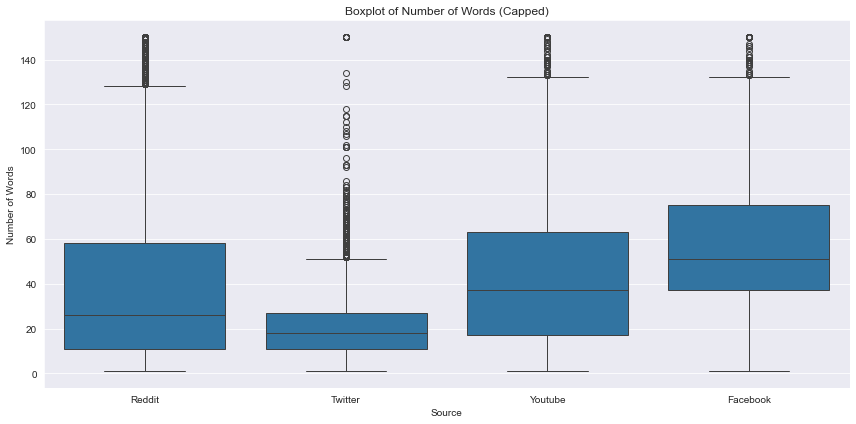

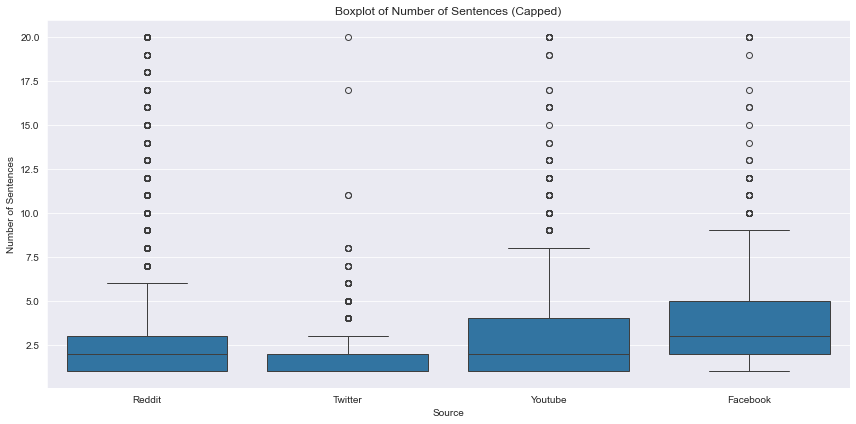

In [32]:
def cap_outliers(df, column, upper_bound):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].apply(lambda x: min(x, upper_bound))
    return df_copy

def plot_num_words(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_words', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_sentences', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs, 150)
plot_num_sentences(dfs, 20)

Now let's examine labels

In [ ]:
def plot_label_distribution(dfs):
    # Prepare the figure for subplots
    num_dfs = len(dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(5 * num_dfs, 6), sharey=True)
    
    if num_dfs == 1:
        axes = [axes]  # Make sure axes is iterable if there's only one DataFrame

    # Plot each DataFrame
    for ax, (name, df) in zip(axes, dfs.items()):
        sns.countplot(x='label', data=df, ax=ax)
        ax.set_title(f'Label Distribution in {name}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_label_distribution(dfs)

In [ ]:
for key, df in dfs.items():
    df1 = df.copy()
    df1.drop(columns=["num_words", "source", "num_sentences"], inplace=True)
    df1.to_csv(os.path.join("..\\data", f"cleaned_{key.lower()}.csv"), index=False)

In [37]:
import re


def clean_text(text):
    """
    Clean the input text by removing Unicode emojis, usernames, and specific special characters.
    Parameters:
        text (str): The text to be cleaned.
    Returns:
        str: The cleaned text.
    """
    # Remove Unicode characters (emojis)
    text = re.sub(r'\\u[0-9A-Fa-f]{4}', '', text)
    # Remove Twitter handles completely
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[!\"#$%&\'()*+,\-./:;<=>?@\[\]^_`{|}~]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_urls(text):
    """
    Remove URLs from a given text string.

    Args:
    text (str): The text from which URLs need to be removed.

    Returns:
    str: The text with URLs removed.
    """
    # Regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    cleaned_text = re.sub(url_pattern, '', text)
    return cleaned_text

def remove_outliers_by_word_length(text, std_dev_threshold=3):
    """
    Remove words from the text that are outliers in terms of their length.

    Args:
    text (str): The input text from which to remove word length outliers.
    std_dev_threshold (int): The number of standard deviations to use as the cutoff. Defaults to 3.

    Returns:
    str: The text with outliers removed.
    """
    words = text.split()
    word_lengths = [len(word) for word in words]

    # Calculate the mean and standard deviation of word lengths
    mean_length = np.mean(word_lengths)
    std_dev_length = np.std(word_lengths)

    # Define word length boundaries
    lower_bound = mean_length - std_dev_threshold * std_dev_length
    upper_bound = mean_length + std_dev_threshold * std_dev_length

    # Filter words that are within the boundary
    filtered_words = [word for word, length in zip(words, word_lengths) if lower_bound <= length <= upper_bound]

    # Join words back into a single string
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text

def apply_cleaning_to_dataframe(df, column_name):
    """
    Apply the cleaning function to a specific column in a DataFrame.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the text to be cleaned.
        column_name (str): The name of the column to clean.
    Returns:
        pandas.DataFrame: The DataFrame with the text in the specified column cleaned.
    """
    df[column_name] = df[column_name].apply(clean_text)

    return df

In [41]:


input_csv_twitter = '../data/cleaned_twitter.csv'
input_csv_yt = '../data/cleaned_youtube.csv'
input_csv_fb = '../data/cleaned_facebook.csv'
input_csv_reddit = '../data/cleaned_reddit_int.csv'

list_of_csvs = [input_csv_twitter, input_csv_yt, input_csv_fb, input_csv_reddit]


# Load the data
df_twitter = pd.read_csv(input_csv_twitter)
df_yt = pd.read_csv(input_csv_yt)
df_fb = pd.read_csv(input_csv_fb)
df_reddit = pd.read_csv(input_csv_reddit)

# list of dataframes
dfs = [df_twitter, df_yt, df_fb, df_reddit]

# apply cleaning to twitter
df_twitter = apply_cleaning_to_dataframe(df_twitter, 'text')

# remove urls from all dfs
for df in dfs:
    df['text'] = df['text'].apply(remove_urls)

# remove outliers by word length from all dfs
for df in dfs:
    df['text'] = df['text'].apply(remove_outliers_by_word_length)


C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

In [ ]:
#import pandas as pd

def undersample(df, label_column):
    # Count the number of each class
    class_counts = df[label_column].value_counts()
    # Find the number of the minority class
    min_class_count = class_counts.min()

    # Create a balanced dataframe by sampling from each class
    df_balanced = pd.concat([
        df[df[label_column] == label].sample(min_class_count, random_state=42)
        for label in class_counts.index
    ])

    return df_balanced

from sklearn.utils import resample

def oversample(df, label_column):
    # Count the number of each class
    class_counts = df[label_column].value_counts()
    # Find the number of the majority class
    max_class_count = class_counts.max()

    # Create a balanced dataframe by sampling from each class
    df_balanced = pd.concat([
        resample(df[df[label_column] == label],
                 replace=True,  # Sample with replacement
                 n_samples=max_class_count,  # Match number in majority class
                 random_state=42)
        for label in class_counts.index
    ])

    return df_balanced



In [ ]:
# Apply undersampling to reddit and twitter
df_twitter_balanced = undersample(df_twitter, 'label')
df_reddit_balanced = undersample(df_reddit, 'label')

for df in [df_twitter_balanced, df_reddit_balanced]:
    print(df['label'].value_counts())

#save them to csv named undersampled_{name}.csv
df_twitter_balanced.to_csv('../data/undersampled_twitter.csv', index=False)
df_reddit_balanced.to_csv('../data/undersampled_reddit.csv', index=False)

In [ ]:
# count values for facebook and youtube
for df in [df_fb, df_yt]:
    print(df['label'].value_counts())